In this exercise we will simulate the accumulation of above-ground plant dry biomass of winter wheat using a simple model driven by photosynthetically active radiation (PAR) and growing degree days (GDD). The model has two routines, one for simulating leaf area index and one for simulating biomass accumulation. This model assumes that there are no environmental limitations other than the input in solar radiation and the changes in air temperature.

The equation modeling the increase in aboveground dry biomass as a function of the intercepted incident solar radiation is:

$$ B_t = B_{t-1} + E_b \; E_{imax} \Bigg[ 1 - e^{-K \; LAI_t} \Bigg] PAR_t$$

The equation modeling the leaf area index as a function of thermal time is:

$$ LAI_t = L_{max} \Bigg[ \frac{1}{1+e^{-\alpha(T_t - T_1)}} -e^{\beta(T_t-T_2)} \Bigg]$$


where parameters are defined by:

$T_2 = \frac{1}{\beta} log[1 + e^{(\alpha \; T_1)}]$<br>
$B$ is above-ground dry biomass in $g m^{-2}$<br>
$T$ is cumulative growing degree days<br>
$t$ is time in days<br>
$LAI$ is the leaf area index<br>
$L{max}$ is the maximum leaf area index during the entire growing season<br>
$PAR$ is the photosynthetically active radiation<br>
$K$ is the coefficient of extiction<br>
$T_1$ is a growth threshold<br>
$E_b$ is the radiation use efficiency<br>
$E_{imax}$ is the maximal value of intercepted to incident solar radiation<br>
$\alpha$ and $\beta$ are empirical parameters<br>


In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Import data
df = pd.read_csv('../datasets/KS_Manhattan_6_SSW.csv', na_values=[-99, -9999])
df.head(3)


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Convert LST_DATE to Pandas datetime format
df.insert(2, "DATES", pd.to_datetime(df["LST_DATE"], format="%Y%m%d"))
df.head(3)


,WBANNO,LST_DATE,DATES,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,2003-10-01,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53974,20031002,2003-10-02,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53974,20031003,2003-10-03,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Check if average temperature or solar radiation have missing values
print('TAVG:', df['T_DAILY_AVG'].isna().sum())
print('SRAD:', df['SOLARAD_DAILY'].isna().sum())


TAVG: 42
SRAD: 39


In [5]:
# Replace missing values using interpolation
df['T_DAILY_AVG'].interpolate(method="pchip", inplace=True)
df['SOLARAD_DAILY'].interpolate(method="pchip", inplace=True)


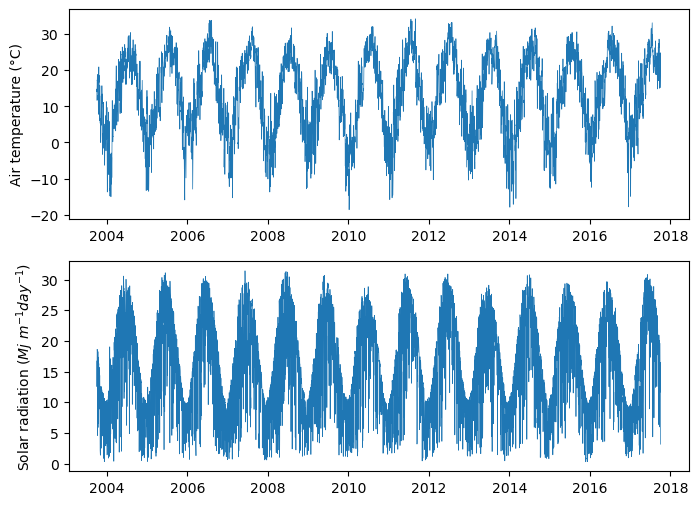

In [6]:
# Let's examine our data with a plot
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(df["DATES"],df["T_DAILY_AVG"], linewidth=0.5)
plt.ylabel(f'Air temperature ({chr(176)}C)')

plt.subplot(2,1,2)
plt.plot(df["DATES"],df["SOLARAD_DAILY"], linewidth=0.5)
plt.ylabel('Solar radiation ($Mj \ m^{-1} day^{-1}$)')

plt.show()


In [7]:
# Define crop parameters
planting_date = "2007-10-01"
planting_date = pd.to_datetime(planting_date)
season_length = 250 # days
harvest_date = planting_date + pd.to_timedelta(season_length, unit='days')


In [8]:
# Define model parameters
Tbase = 4
Eb = 1.85
Eimax = 0.94
K = 0.7
Lmax = 7
T1 = 900
alpha = 0.005
beta = 0.002
T2 = 1/beta * np.log(1 + np.exp(alpha*T1))
HI = 0.45 # Approximate harvest index


In [9]:
# Define model equations as lambda functions
calculate_LAI = lambda x: np.maximum(Lmax*(1/(1+np.exp(-alpha*(x-T1))) - np.exp(beta*(x-T2))),0)
calculate_B = lambda LAI,PAR: Eb * Eimax * (1-np.exp(-K*LAI)) * PAR
calculate_GDD = lambda T, Tbase: np.maximum(T - Tbase, 0)


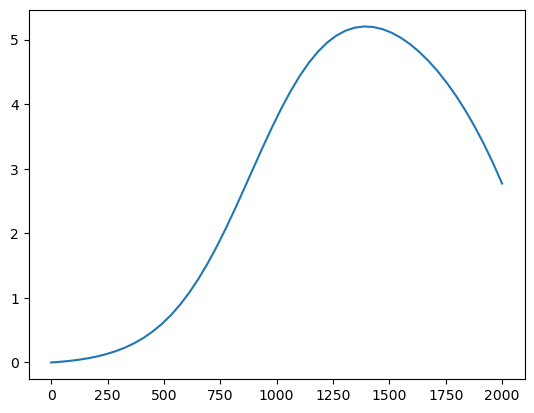

In [10]:
plt.plot(np.linspace(0,2000), calculate_LAI(np.linspace(0,2000)))

## Single growing season

For simulating a single crop growing season the easiest approach is to select the rows of the historic weather record matching the specified growing season and then iterating over each day. More advanced methods could use a `while` loop to check if a condition, like the number of GDD, have been met to terminate the growing season.


In [11]:
# Select records for growing season
idx_growing_season = (df["DATES"] >= planting_date) & (df["DATES"] <= harvest_date)
df_season = df.loc[idx_growing_season,:].reset_index(drop=True)
df_season.head(3)


,WBANNO,LST_DATE,DATES,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20071001,2007-10-01,1.302,-96.61,39.1,28.2,7.1,17.6,18.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53974,20071002,2007-10-02,1.302,-96.61,39.1,28.2,9.3,18.7,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53974,20071003,2007-10-03,1.302,-96.61,39.1,26.6,5.9,16.2,16.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Initial conditions
GDD = calculate_GDD(df_season["T_DAILY_AVG"].iloc[0], Tbase)
LAI = np.array([0])
B = np.array([0])

# Iterate over each day
# We start from day 1, since we depend on information of the previous day
for k,t in enumerate(range(1,df_season.shape[0])):

    # Compute growing degree days
    GDD_day = calculate_GDD(df_season["T_DAILY_AVG"].iloc[t], Tbase)
    GDD = np.append(GDD, GDD_day)

    # Compute leaf area index
    LAI_day =  calculate_LAI(GDD.sum())
    LAI = np.append(LAI, LAI_day)

    # Estimate PAR from solar radiation (about 48%)
    PAR_day = df_season["SOLARAD_DAILY"].iloc[t] * 0.48
    
    # Compute daily biomass
    B_day = calculate_B(LAI[t], PAR_day)

    # Compute cumulative biomass
    B = np.append(B, B[-1] + B_day)


In [13]:
# Add variable to growing season dataframe, 
# so that we have everything in one place.
df_season['LAI'] = LAI
df_season['GDD'] = GDD
df_season['B'] = B

df_season.head(3)

,WBANNO,LST_DATE,DATES,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,...,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,LAI,GDD,B
0,53974,20071001,2007-10-01,1.302,-96.61,39.1,28.2,7.1,17.6,18.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,14.9,0.000000
1,53974,20071002,2007-10-02,1.302,-96.61,39.1,28.2,9.3,18.7,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008062,17.0,0.065197
2,53974,20071003,2007-10-03,1.302,-96.61,39.1,26.6,5.9,16.2,16.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011653,12.3,0.198516


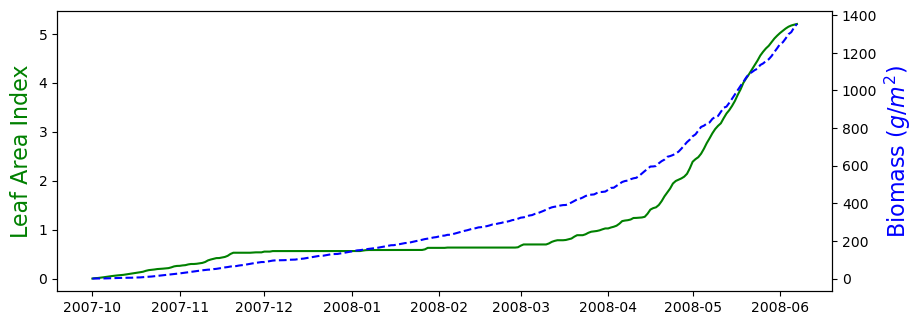

In [14]:
# Generate figure for growing season LAI and Biomass
plt.figure(figsize=(10,8))

# Leaf area index
plt.subplot(2,1,1)
plt.plot(df_season['DATES'], df_season['LAI'], '-g')
plt.ylabel('Leaf Area Index', color='g', size=16)

# Biomass
plt.twinx()
plt.plot(df_season['DATES'], df_season['B'], '--b')
plt.ylabel('Biomass ($g/m^2$)', color='b', size=16)

plt.show()


In [15]:
# Estimate grain yield
Y = df_season['B'].iloc[-1]*HI # grain yield in g/m^2
Y = Y * 10_000/1000 # Convert to kg per hectare (1 ha = 10,000 m^2) and (1 kg = 1,000 g)
print(f'Wheat yield potential is: {Y:.1f} kg per hectare')


Wheat yield potential is: 6090.5 kg per hectare


## Practice

- Modify the code so that the model stops when the crop accumulated a total of 2400 GDD. Hint: You no longer a harvest date and you may want to consider using a `while` loop.

## References

Brun, F., Wallach, D., Makowski, D. and Jones, J.W., 2006. Working with dynamic crop models: evaluation, analysis, parameterization, and applications. Elsevier.